# Local Lengthscale GP with PyMC

In this chapter, we explore a non-stationary GP discussed by {cite}`LLSGP` with PyMC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pymc3 as pm
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

rc('font', size=16)

Let us define both stationary and non-statioanry RBF kernels,

In [2]:
### Stationary GP
def kernel(a, b, lenghtscale, std):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.square(a - b.T)
    return std**2*np.exp(-.5 * (1/lenghtscale) * sqdist)

### LLS GP
def global_kernel(x1, x2, l1, l2, std):
    sqdist = np.square(x1 - x2.T)
    l1l2meansqr = (np.square(l1)[:, np.newaxis, :] + np.square(l2)[np.newaxis, :, :]).squeeze()/2
#     print(sqdist.shape, l1l2meansqr.shape)
    return std**2 * pm.math.matrix_dot(np.sqrt(l1),np.sqrt(l2.T)) * (1/np.sqrt(l1l2meansqr)) * np.exp(-sqdist/l1l2meansqr)

def local_kernel(x1, x2, lengthscale):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.square(x1 - x2.T)
    return np.exp(-.5 * (1/lengthscale) * sqdist)

We will test the efficacy of these models on a step function data.

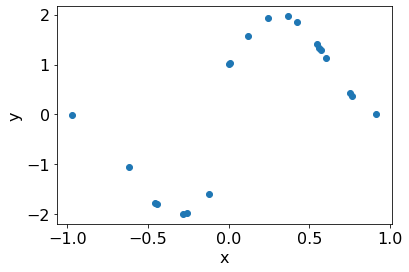

In [3]:
n_train = 20
np.random.seed(1234)

# Generate data
def f(X):  # target function
    return np.sin(5*X) + np.sign(X)

X = np.random.uniform(-1, 1, (n_train, 1)).reshape(-1,1)  # data
Y = f(X)[:, 0]
plt.scatter(X, Y);
plt.xlabel('x');
plt.ylabel('y');

### Stationary GP model

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    # Variance
    kernel_std = pm.Lognormal("kernel_std", 0, 0.1)
    # Length scale
    kernel_ls = pm.Lognormal("kernel_ls", 0, 1)
    noise_sigma = pm.Lognormal("noise_sigma", 0, 1)
    K = kernel(X, X, kernel_ls, kernel_std) 
    K += np.eye(X.shape[0]) * np.power(noise_sigma, 2)
    
    y = pm.MvNormal("y", mu = 0, cov = K, observed = Y.squeeze())

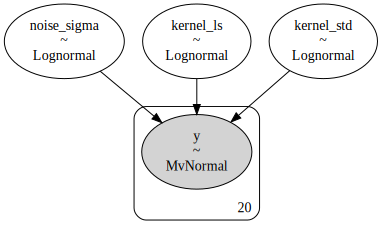

In [5]:
pm.model_to_graphviz(basic_model.model)

Let us find MAP estimate of paramaters.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'kernel_std_log__': array(0.02551201),
 'kernel_ls_log__': array(-2.64629795),
 'noise_sigma_log__': array(-1.33736405),
 'kernel_std': array(1.02584022),
 'kernel_ls': array(0.07091325),
 'noise_sigma': array(0.26253679)}

Now, we will sample from the posterior.

In [7]:
with basic_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sigma, kernel_ls, kernel_std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


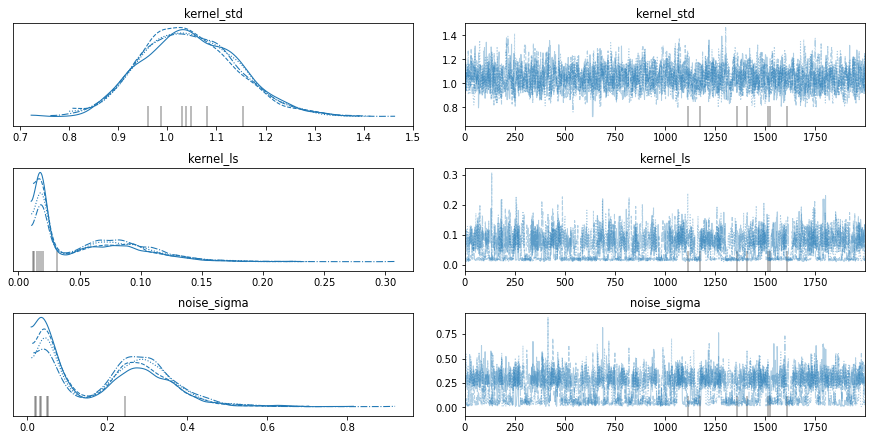

In [8]:
import arviz as az

az.plot_trace(trace);

Now, we will infer the $y$ values at new input locations.

In [11]:
test_x = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(train_x, train_y, test_x, kernel, kernel_ls, kernel_std, noise):
    N = len(train_x)
    K = kernel(train_x, train_x, kernel_ls, kernel_std)+noise**2*np.eye(len(train_x))
    N_star = len(test_x)
    K_star = kernel(train_x,  test_x, kernel_ls, kernel_std)
    K_star_star = kernel(test_x, test_x, kernel_ls, kernel_std)
    posterior_mu = K_star.T@np.linalg.inv(K)@(train_y)
    posterior_sigma = K_star_star - K_star.T@np.linalg.inv(K)@K_star
    
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu, posterior_sigma, size=1)

In [12]:
# Make predictions at new locations.
train_y = Y.squeeze()
n_samples = 500
preds = np.stack([post(train_x, train_y, test_x=test_x, kernel=kernel, kernel_ls=trace['kernel_ls'][b],
                             kernel_std=trace['kernel_std'][b],
                             noise=trace['noise_sigma'][b])
                  for b in range(n_samples)])

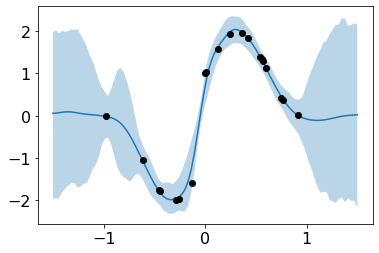

In [13]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');

### LLS GP

We will learn local lengthscales at 3 input locations choosen by KMeans clustering.

In [18]:
n_local = 5
lls_model = pm.Model()
param_X = KMeans(n_local).fit(X).cluster_centers_

with lls_model:
    
    ### Local GP
    # local lengthscale
    local_ls = pm.Lognormal("local_ls", 0, 100)
    param_ls = pm.Lognormal("param_ls", 0, 100, shape=(n_local, 1))
    local_K = local_kernel(param_X, param_X, local_ls)
    local_K_star = local_kernel(X, param_X, local_ls)
    
    ### global GP
    # global lengthscales
    local_K += np.eye(n_local)*10**-5
    global_ls = pm.math.exp(pm.math.matrix_dot(local_K_star, pm.math.matrix_inverse(local_K), pm.math.log(param_ls)))
    # global variance
    global_std = pm.Lognormal("global_std", 0, 10)
    # global noise
    global_noise_sigma = pm.Lognormal("global_noise_sigma", 0, 10)
    
    global_K = global_kernel(X, X, global_ls, global_ls, global_std)
    global_K += np.eye(X.shape[0])*global_noise_sigma**2
    
    y = pm.MvNormal("y", mu = 0, cov = global_K, observed = Y.squeeze())

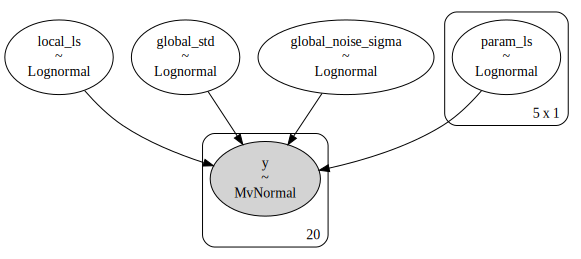

In [19]:
pm.model_to_graphviz(lls_model.model)

Let us find MAP estimate of paramaters.

In [20]:
NSmap_estimate = pm.find_MAP(model=lls_model)
NSmap_estimate

{'local_ls_log__': array(-11.3572818),
 'param_ls_log__': array([[ 7.33000234],
        [ 3.86089057],
        [14.28029792],
        [-5.61996201],
        [-7.70033797]]),
 'global_std_log__': array(6.36848704),
 'global_noise_sigma_log__': array(-26.58247985),
 'local_ls': array(1.16840978e-05),
 'param_ls': array([[1.52538535e+03],
        [4.75076416e+01],
        [1.59167571e+06],
        [3.62477882e-03],
        [4.52674166e-04]]),
 'global_std': array(583.17484016),
 'global_noise_sigma': array(2.85348562e-12)}

In [21]:
with lls_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_noise_sigma, global_std, param_ls, local_ls]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 285 seconds.
There were 828 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1355 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.575334914233337, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1032 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6295404199098328, but should be close to 0.8. Try to increase the number of tuning steps.
There were 841 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6646884673425586, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estim

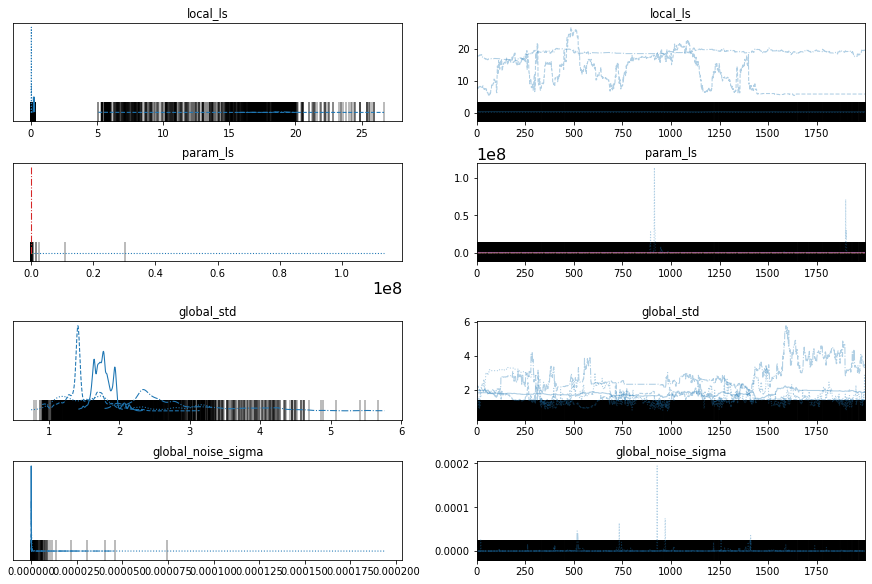

In [18]:
import arviz as az
with lls_model:
    az.plot_trace(trace);

Let us predict the values at new locations.

In [53]:
test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(local_ls, param_ls, global_std, global_noise):
    N = len(train_x)
    param_K_inv = np.linalg.inv(local_kernel(param_X, param_X, local_ls))
    local_K = local_kernel(train_x, param_X, local_ls)
    global_ls = np.exp(local_K@param_K_inv@param_ls)
    local_K_star = local_kernel(test_x, param_X, local_ls)
    global_ls_star = np.exp(local_K_star@param_K_inv@param_ls)
#     print(global_noise)
    K = global_kernel(train_x, train_x, global_ls, global_ls, global_std)+np.eye(N)*global_noise**2
    K_inv = pm.math.matrix_inverse(K)
    K_star = global_kernel(train_x, test_x, global_ls, global_ls_star, global_std)
    posterior_mu = pm.math.matrix_dot(K_star.T,K_inv,train_y)
#     K_star_star = global_kernel(test_x, test_x, global_ls_star, global_ls_star, global_std)
#     posterior_sigma = K_star_star - pm.math.matrix_dot(K_star.T,K_inv,K_star)
    
    return posterior_mu.eval()
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu.eval(), posterior_sigma.eval(), size=1)

In [54]:
# Make predictions at new locations.
n_samples = 70

preds = np.stack([post(local_ls=trace['local_ls'][b],
                       param_ls=trace['param_ls'][b],
                       global_std=trace['global_std'][b],
                      global_noise=trace['global_noise_sigma'][b])
                  for b in range(n_samples)])

Let us visualize predictive mean and variance.

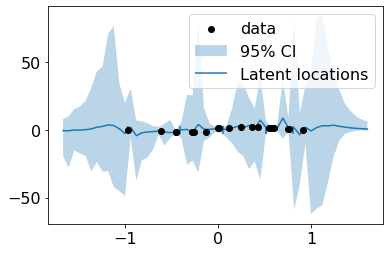

In [55]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');
for x_loc in param_X:
    plt.vlines(x_loc, -3, 3);
plt.vlines(x_loc, -3, 3, label='Latent locations');
plt.legend(bbox_to_anchor=(1,1));

Let us compare the latent lengthscales and stationary lengthscales.